In [93]:
import geopandas as gpd
import pandas as pd
import s3fs
import numpy as np
import math
from shapely.geometry import Polygon, box
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

# 1. Read Observation Data into Geopandas Frame

In [2]:
DATASET_PATH = '../data/full_dataset.csv'
RASTER_PATH = '../data/rasters/'

In [95]:

BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/observations'
train_file, test_file = 'observations_us_train.csv', 'observations_us_test.csv'
s3_train_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, train_file)

In [96]:
train_usa = pd.read_csv(s3_train_path,header='infer', sep=';',)
train_usa.head()

,observation_id,latitude,longitude,species_id,subset
0,20000173,33.197660,-116.180680,4911,train
1,20000175,34.037968,-118.876755,4912,train
2,20000176,27.620740,-97.222690,4913,train
3,20000177,29.155582,-95.653930,4914,train
4,20000179,36.605740,-121.959510,4915,train


In [97]:
train_df, val_df = train_usa[train_usa.subset == 'train'], train_usa[train_usa.subset == 'val']
len(train_df), len(val_df)

(931132, 25099)

In [6]:
del train_usa

In [98]:
train_gdf = gpd.GeoDataFrame(train_df, geometry=gpd.points_from_xy(train_df.longitude, train_df.latitude))\
                .drop(['latitude', 'longitude'], axis=1).set_crs(4326)
# train_gdf.to_crs
train_gdf.head()

,observation_id,species_id,subset,geometry
0,20000173,4911,train,POINT (-116.18068 33.19766)
1,20000175,4912,train,POINT (-118.87676 34.03797)
2,20000176,4913,train,POINT (-97.22269 27.62074)
3,20000177,4914,train,POINT (-95.65393 29.15558)
4,20000179,4915,train,POINT (-121.95951 36.60574)


In [8]:
train_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# 2. Create grid for USA (AOI)

## 2.1 Use a generic map outline for the USA

In [100]:
import geopandas as gpd
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

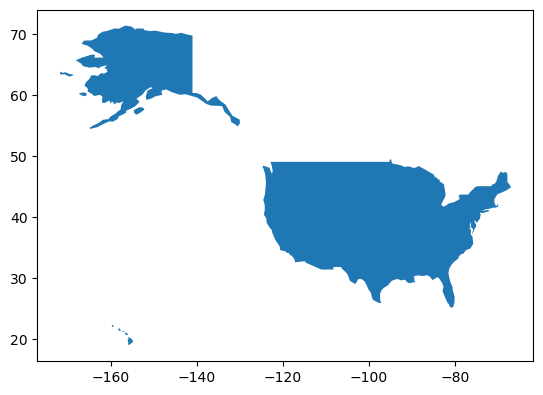

In [101]:
usa = world[world['name'] == 'United States of America']
usa.plot()

## 2.1 Now we only want continental USA, so clip to continental bounds

<AxesSubplot:>

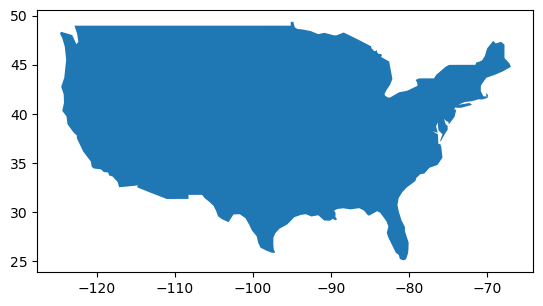

In [102]:
from shapely.geometry import Polygon

continental_bounds = Polygon([(-130,50), (-60,50), (-60,20), (-130,20)])
usa = usa.clip(continental_bounds)
usa.plot()

# 3. Species Level Kernel Function

## 3.1 Extract one species to test with

In [12]:
species_id_counts = train_df.species_id.value_counts()
species_id_counts.min()

1

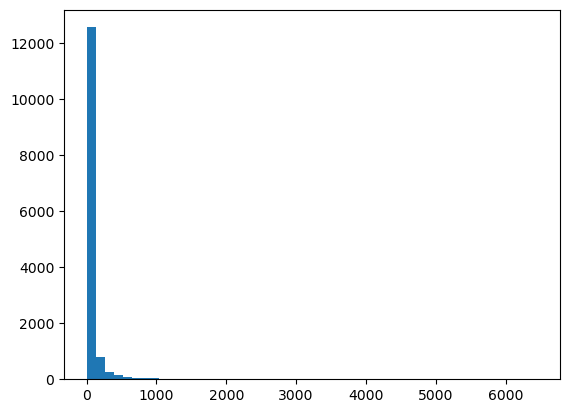

In [13]:
plt.hist(species_id_counts, bins=50)
plt.show()

## Build a class with all the data and functions needed for gridding and kernels

In [14]:
%load_ext autoreload

In [15]:
#Run this to reload the python file
%autoreload 2
from grid_dask import *


In [19]:
shutdown_all_clusters()

In [20]:
cluster, client = setup_dask_cluster(max=113,mem=32)

Setting up new cluster..
Getting client..
<Client: 'tls://10.244.99.187:8786' processes=0 threads=0, memory=0 B>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.6e635ce4926b4ca4980ef1a4c4efe4f7/status


In [21]:
grid_res = 0.1
obs_usa = Observations(train_gdf, usa, grid_res_deg=grid_res)

Gridding..
Creating Land Mask..
Num entries before masking:  142680
Num entries after masking:  85149
<Client: 'tls://10.244.99.187:8786' processes=43 threads=43, memory=1.34 TiB> https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.6e635ce4926b4ca4980ef1a4c4efe4f7/status
(85149, 2)


In [22]:
obs_usa.grid_gd

,geometry,grid_id
0,"POLYGON ((-124.68721 48.18000, -124.68721 48.2...",0
1,"POLYGON ((-124.58721 47.88000, -124.58721 47.9...",1
2,"POLYGON ((-124.58721 47.98000, -124.58721 48.0...",2
3,"POLYGON ((-124.58721 48.08000, -124.58721 48.1...",3
4,"POLYGON ((-124.58721 48.18000, -124.58721 48.2...",4
...,...,...
85144,"POLYGON ((-67.08721 44.98000, -67.08721 45.080...",85144
85145,"POLYGON ((-66.98721 44.68000, -66.98721 44.780...",85145
85146,"POLYGON ((-66.98721 44.78000, -66.98721 44.880...",85146
85147,"POLYGON ((-66.98721 44.88000, -66.98721 44.980...",85147


In [23]:
del train_gdf

### Optimized grid testing

In [ ]:
unique, counts = np.unique(obs_usa.land_mask, return_counts=True)

#display unique values and counts side by side
print(np.asarray((unique, counts)).T)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
obs_usa.grid_gd.plot(ax=ax, column='mask', edgecolor = 'none', legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
# usa.plot(ax=ax,  color='none')
# train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

In [ ]:
w = usa.simplify(0.1).geometry
w.iloc[0]

In [ ]:
series = obs_usa.grid_gd.within(w.iloc[0]).to_numpy()

unique, counts = np.unique(series, return_counts=True)

#display unique values and counts side by side
print(np.asarray((unique, counts)).T)

In [ ]:
obs_usa.grid_gd.loc[5510:5520].geometry.centroid

In [ ]:
obs_usa.grid_np[5510:5521]

### Combine chosen_species_grid into the primary observations grid with the following structures:

**Possibility A: Per observation**

| SpeciesID | Probability | GridID | Geometry |
| --- | --- | --- | --- |
| 115 | 0.7 | 7743 | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |


Or

**Possibility B: Per Grid**

| SpeciesID | SpeciesID | ... | SpeciesID | GridID | Geometry |
| --- | --- | --- | --- | --- | --- |
| 115 | 4443 | ... | 19328 | 52  | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |

We pick option A, since it provides a more memory efficient method

## Grid and KDE all species

In [24]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.6e635ce4926b4ca4980ef1a4c4efe4f7/status,


## Dask KDE Functions

In [30]:
test = np.array([256,255,300])
test = test.astype('uint8')
test

array([  0, 255,  44], dtype=uint8)

In [43]:
import dask
def kernel_per_species(grid_gd, grid_np, gdf_chosen, 
                       kde:bool=True, chosen_id:int=0, cumulative:bool=False, 
                       radius:float=0.5, kernel:str='gaussian', q:int=8):

    """
    Inputs:
    kde: whether or not to apply KDE
        if False: only group observations within a cell
        if True: group and then apply KDE
    chosen_id: Species ID for a single chosen species
    grid: grid to which these observations must conform
    radius: radius in degrees for the kernel function
    kernel: 'linerar' / 'epanechnikov' / 'gaussian' ..
    cumulative: keep adding to a master species list -> grid_kde
    Quantization: whether or not to quantize to some int value : 8,16,32,64

    Output:

    """
    # Remove duplicate counts
    # With intersect, those that fall on a boundary will be allocated to all cells that share that boundary
    # chosen_species_grid = chosen_species_grid.drop_duplicates(subset = ['speciesID']).reset_index(drop = True)

    chosen_species_grid = gpd.sjoin(gdf_chosen, grid_gd, how='inner', predicate='within').drop(['index_right'], axis=1)
    # display(chosen_species_grid)

    # Add a field with constant value of 1
    chosen_species_grid['num_obs'] = 1.0

    # Group GeoDataFrame by cell while aggregating the Count values
    chosen_species_grid = chosen_species_grid.groupby('grid_id').agg({'num_obs':'sum'})

    chosen_species_grid = grid_gd.merge(chosen_species_grid, on = 'grid_id', how = "right")

    if (kde and radius*2 > grid_res):

        #List of grids that have observations for this species
        chosen_grids = list(chosen_species_grid['grid_id'])
        # print(chosen_grids, chosen_species_grid)
        #sanity check
        if len(chosen_grids) == 0:
            return 

        # Create training set for KDE
        x_train = grid_np[chosen_grids,:]
        y_train = chosen_species_grid['num_obs'].to_numpy()


        tree = KDTree(x_train)
        y_hat = tree.kernel_density(grid_np, h=radius, kernel=kernel)*(1*(radius**2))

        # y_hat /= y_hat.max()
        # print("Max y_hat = ", y_hat.max())
        #Cap all cells at 1
        y_hat[y_hat > 1.0] = 1.0
        y_hat[y_hat < 1e-5] = 0.0
        
        if (q > 0):
            #let's say by default it's int8
            y_hat = (y_hat * 255).astype('uint8')

        return y_hat


                   
def kde(obs, classes, radius:float=1.0, kernel:str='gaussian'):
    """Populates the grid_kde data structure
       with 1 column per species_id for every grid_cell
       **fingers crossed**
    """
    y_hats = []
    
    # grid_gd = obs.grid_gd
    # grid_np = obs.grid_np
    # gdf_obs = obs.gdf_obs
    
    #Trying this
    #SUPER CRUCIAL for memory and speedup!
    grid_gd = dask.delayed(obs.grid_gd)
    grid_np = dask.delayed(obs.grid_np)

    # print("Building Parallel Compute Graph")

    for id in classes:
        gdf_chosen = dask.delayed(obs.gdf_obs[obs.gdf_obs.species_id==id])
        # gdf_chosen = obs.gdf_obs[obs.gdf_obs.species_id==id]
        y_hats.append(dask.delayed(kernel_per_species)(grid_gd=grid_gd, grid_np=grid_np, gdf_chosen=gdf_chosen, 
                                         kde=True, chosen_id=id, radius=radius, kernel=kernel, cumulative=True))
    # print("Ready for parallel compute...")
    return y_hats   

def requantize_batch(arr, q:int=8):
    out = []
    denom = 2**q - 1
    for a in arr:
        out.append(a.astype('float16')/denom)
        
    return out

In [33]:
# obs_usa.class_list
classes = obs_usa.class_list[0:20]


In [44]:
# cluster.scale(100)
# prob_kde = dask.delayed(kde)(obs_usa,classes)
prob_kde = kde(obs_usa,classes)

In [45]:
prob_kde = dask.compute(prob_kde)

In [48]:
from sys import getsizeof

In [50]:
prob_kde[0][19].max(), prob_kde[0][0].dtype, getsizeof(prob_kde[0][19])

(163, dtype('uint8'), 85261)

In [51]:
prob_kde2 = requantize(prob_kde[0])

In [52]:
prob_kde2[19].max(), len(prob_kde2[19]), getsizeof(prob_kde2[19])

(0.639, 85149, 170410)

## Break up the task into batches

In [53]:
#this works!

total_classes, inc = len(obs_usa.class_list), 300

def set_classes(min_id, inc):
    max_id = min_id + inc

    if (max_id > total_classes):
        max_id = total_classes + 1
    
    print(min_id, max_id-1)
    return obs_usa.class_list[min_id:max_id]

print(total_classes, inc)

def batch(df, classes):
    sub_results = []
    sub_results.append(kde(obs_usa,classes))
    return sub_results




batches = []

for i in range(0, total_classes+1, inc):
    classes = set_classes(i,inc)
    result_batch = batch(obs_usa, classes)
    batches.append(result_batch)
    
print("Num Batches [1st index]: ", len(batches))
print("Num of classes in each batch (except last) []: ", inc)


14124 300
0 299
300 599
600 899
900 1199
1200 1499
1500 1799
1800 2099
2100 2399
2400 2699
2700 2999
3000 3299
3300 3599
3600 3899
3900 4199
4200 4499
4500 4799
4800 5099
5100 5399
5400 5699
5700 5999
6000 6299
6300 6599
6600 6899
6900 7199
7200 7499
7500 7799
7800 8099
8100 8399
8400 8699
8700 8999
9000 9299
9300 9599
9600 9899
9900 10199
10200 10499
10500 10799
10800 11099
11100 11399
11400 11699
11700 11999
12000 12299
12300 12599
12600 12899
12900 13199
13200 13499
13500 13799
13800 14099
14100 14124
Num Batches [1st index]:  48
Num of classes in each batch (except last) []:  300


In [54]:
kde_grids = dask.compute(batches) ##Be patient - takes about 1-2 mins to start on the cluster dashboard

In [55]:
kde_grids[0][46][0][299].max()

40

In [56]:
len(kde_grids[0][0][0]), type(kde_grids[0][0][0][0]), kde_grids[0][0][0][1].shape, kde_grids[0][0][0][99]

(300,
 numpy.ndarray,
 (85149,),
 array([ 8, 13, 12, ...,  9,  9,  8], dtype=uint8))

In [57]:
len(kde_grids[0][1][0]), len(kde_grids[0])

(300, 48)

In [61]:
getsizeof(kde_grids[0][0][0][99])

85261

## Unpack nested list

**Dimension 1 [0][b] : Batch number** -> Iterate over kde_grids[0][0:num_batches] in outermost loop -> List


**Dimension 4 [0][b][0][id] : Id number within that batch** -> Iterate over kde_grids[0][b][0][id]

In [ ]:
def requantize(arr, q:int=8):
    out = []
    denom = 2**q - 1
    for a in arr:
        out.append(a.astype('float16')/denom)
        
    return out

In [63]:
#inc is the number of classes in each batch
# %%time
import warnings
warnings.filterwarnings('ignore')

kde_gdf = obs_usa.grid_gd.copy()

for i, batch in enumerate(kde_grids[0]):
    # print (i)
    for j, kde in enumerate(batch[0]):
        # print(j)
        class_index = inc*i + j
        chosen_id = obs_usa.class_list[class_index]
        col_name = 'prob_{}'.format(chosen_id)
        # print(col_name)
        kde_gdf[col_name] = kde
        # print (type(kde))
        

In [65]:
len(kde_gdf)

85149

In [79]:
kde_gdf.head(2)

,geometry,grid_id,prob_4911,prob_4912,prob_4913,prob_4914,prob_4915,prob_4916,prob_2950,prob_4917,...,prob_2309,prob_2897,prob_1460,prob_3932,prob_1436,prob_1948,prob_4678,prob_1232,prob_2985,prob_272
0,"POLYGON ((-124.68721 48.18000, -124.68721 48.2...",0,0,0,0,0,38,0,88,0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((-124.58721 47.88000, -124.58721 47.9...",1,0,0,0,0,40,0,108,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
filename = "geolifeclef_usa_0.1deg_kde_1deg.pkl"
kde_gdf.to_pickle(filename)


## Test reading back feather file

In [88]:
chosen_id = 4912
col_name = 'prob_{}'.format(chosen_id)

kde_gdf_unpkl = pd.read_pickle(filename)


In [87]:
type(kde_df_unpkl)

geopandas.geodataframe.GeoDataFrame

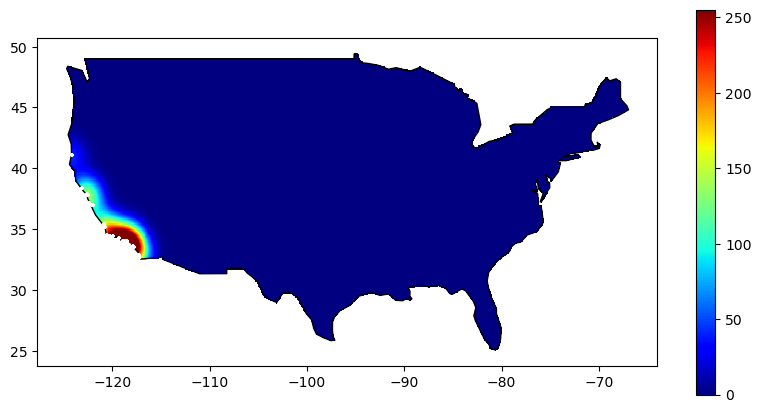

In [103]:
chosen_id = 4912
col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kde_gdf_unpkl.plot(ax=ax, column=col_name, edgecolor = 'none', legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

### If we wanted to save a new file for every batch for memory reasons, we would use this

[[UNTESTED]]

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')


# for i, batch in enumerate(kde_grids[0]):
#     # print (i)
#     kde_gdf = obs_usa.grid_gd.copy()
#     filename = "geolifeclef_usa_0.5deg_kde"
    
#     for j, kde in enumerate(batch[0]):
#         # print(j)
#         class_index = inc*i + j
#         chosen_id = obs_usa.class_list[class_index]
#         col_name = 'prob_{}'.format(chosen_id)
#         # print(col_name)
#         kde_gdf[col_name] = kde
#         # print (type(kde))
#     save_gdf()
        

## Memory cleanup

In [27]:
%whos

Variable                      Type              Data/Info
---------------------------------------------------------
BUCKET_NAME                   str               datasets-sdm
DATASET_PATH                  str               ../data/full_dataset.csv
KDTree                        type              <class 'sklearn.neighbors._kd_tree.KDTree'>
KernelDensity                 type              <class 'sklearn.neighbors._kde.KernelDensity'>
Observations                  type              <class 'grid_dask.Observations'>
Polygon                       type              <class 'shapely.geometry.polygon.Polygon'>
RASTER_PATH                   str               ../data/rasters/
batch                         list              n=1
batches                       list              n=48
box                           function          <function box at 0x7fa0f1b33910>
check_for_existing_clusters   function          <function check_for_exist<...>usters at 0x7fa0d0eab010>
chosen_id                     int64 

In [67]:
kde_grids = None
obs_usa = None
kde = None

In [72]:
import gc 
gc.collect()

565

In [68]:
del kde, kde_grids

In [71]:
del batches, batch

# Test Stuff

### TEST Displays
Let's take species ID: 115, that has 723 observations across the USA

In [ ]:
chosen_id = 115
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.0, kernel='gaussian', cumulative=True)

In [ ]:
obs_usa.grid_kde

In [ ]:
kernels = obs_usa.grid_kde

In [ ]:
col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kernels.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

#### Let's do a few more and make it cumulative

In [ ]:
chosen_id = 4911
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.3, kernel='epanechnikov', cumulative=True)


In [ ]:
chosen_id = 46
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=2.0, kernel='linear', cumulative=True)

In [ ]:
obs_usa.grid_kde

In [ ]:
kernels = obs_usa.grid_kde.clip(usa).reset_index(drop=True)

col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kernels.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
ax.set_title('Probability Field of Species {}'.format(chosen_id))
plt.show()

In [ ]:
obs_usa.clear_kde()

## Test Dask Clusters

In [ ]:
import time, random

In [ ]:
@dask.delayed
def inc(x,n):
    time.sleep(random.random())
    return x ** n
@dask.delayed
def dec(x,n):
    time.sleep(random.random())
    return x ** (1/n)
@dask.delayed
def add(x, y):
    time.sleep(random.random())
    return x + y

In [ ]:
%%time

def compound(w,n):
    zs = []
    for i in range(1,n):
        x = inc(w,i)
        y = dec(w,i)
        z = add(x, y)
        zs.append(z)
        
    return zs

In [ ]:
%%time
#zs = dask.persist(*zs)  # trigger computation in the background

x = np.random.rand(30,30) # some large array
# x = dask.delayed(x) #need to delay array also
zs = dask.compute(compound(x,100))